## Names: 
### Jaagrit Arora, Sankalp Devasthali, Garvit Harisinghani
## Andrew ID:
### jarora, sdevasth, gharisin

In [1]:
import scipy.io 
import keras
from matplotlib import pyplot as plt
import cv2
import numpy as np
train_x = scipy.io.loadmat('SVHN/train_32x32.mat',variable_names = 'X').get('X')
train_y = scipy.io.loadmat('SVHN/train_32x32.mat',variable_names = 'y').get('y')
test_x = scipy.io.loadmat('SVHN/test_32x32.mat',variable_names = 'X').get('X')
test_y = scipy.io.loadmat('SVHN/test_32x32.mat',variable_names = 'y').get('y')

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Variables
**captcha_labels**: labels of a given House Plate image. Eg "A77X" for image bearing House plate 88.  
**images**: a list of filepath for images of the dataset.  
**X_train [~test]**: The data we will be training and testing on.   
**training_labels [~testing]**: The labels we will be training and testing on. 
**y_train [~test]**: The one hot encoded labels we will be training and testing on.   
**onehot**: a ONE-HOT encoded representation of all labels within our dataset.  
**IMG_WIDTH**: the width of all our images for representation and training.  
**IMG_HEIGHT**: the width of all our images for representation and training.  

#### Models 
**model_advanced**: an advanced Neural Network with multiple layers.  
**tsne**: a T-SNE model for visualization.

In [2]:
def image_preprocess(img):
    _,digit = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    digit = digit/255
    if np.sum(digit[:digit.shape[0],:3] <= (digit.shape[0]*3*0.1)):
        for a in range(digit.shape[0]):
            for b in range(digit.shape[1]):
                if digit[a,b] == 0:
                    digit[a,b] = 1
                else:
                    digit[a,b] = 0
                    
    return digit

In [3]:
%%time
#Converting training dataset into gray for 10000 images
train_x_gray = []
test_x_gray = []
for i in range(train_x.shape[3]):#replace with train_x.shape[3] for full dataset or range(_number_)
    temp_denoise = cv2.fastNlMeansDenoisingColored(train_x[:,:,:,i],None,10,10,7,21)
    temp_denoise = cv2.cvtColor(temp_denoise, cv2.COLOR_BGR2GRAY)
    train_x_gray.append(image_preprocess(temp_denoise))
for i in range(test_x.shape[3]):#replace with test_x.shape[3] for full dataset or range(_number_)
    temp_denoise = cv2.fastNlMeansDenoisingColored(test_x[:,:,:,i],None,10,10,7,21)
    temp_denoise = cv2.cvtColor(temp_denoise, cv2.COLOR_BGR2GRAY)
    test_x_gray.append(image_preprocess(temp_denoise))

Wall time: 49min 24s


In [4]:
x_train = np.array(train_x_gray)
x_test = np.array(test_x_gray)
training_labels = [x[0] for x in train_y]#[:_number_]
testing_labels = [x[0] for x in test_y]#[:_number_]

In [5]:
%%time
label_list = list(set(training_labels))
number_of_labels = len(set(label_list))
onehot = np.identity(number_of_labels)

train_labels = {}
for i in range(len(label_list)):
    train_labels[label_list[i]] = onehot[i]

test_labels = {}
for j in range(len(label_list)):
    test_labels[label_list[j]] = onehot[j]
    
y_train = np.array([train_labels[y] for y in training_labels])
y_test = np.array([test_labels[y] for y in testing_labels])

Wall time: 46.9 ms


In [6]:
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras import models, layers

model_advance = models.Sequential()
model_advance.add(layers.Conv2D(number_of_labels, (3,3), activation='relu',input_shape = (x_train.shape[1],x_train.shape[2],1)))
model_advance.add(layers.MaxPool2D((2,2)))
model_advance.add(layers.Flatten())
model_advance.add(layers.Dense(number_of_labels, activation = 'softmax'))
model_advance.summary()
model_advance.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_advance.fit(x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],-1), y_train, epochs=10, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                22510     
Total params: 22,610
Trainable params: 22,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
73257/73257 [==============================] - 27s 374us/step - loss: 1.3035 - acc: 0.5820
Epoch 2/10
73257/73257 [==============================] - 27s 373us/step - loss: 0.9874 - acc: 0.6851
Epoch 3/10
73257/73257 [==============================] - 31s 422u

In [7]:
test_loss, test_acc = model_advance.evaluate(x_test.reshape(x_test.shape[0],x_train.shape[1],x_train.shape[2],-1), y_test)
print('Test los:', test_loss, 'Test accuracy:', test_acc)

26032/26032 [==============================] - 6s 231us/step
Test los: 0.9467362286345535 Test accuracy: 0.7033266748617086


In [8]:
y_pred = model_advance.predict_classes(x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],-1))

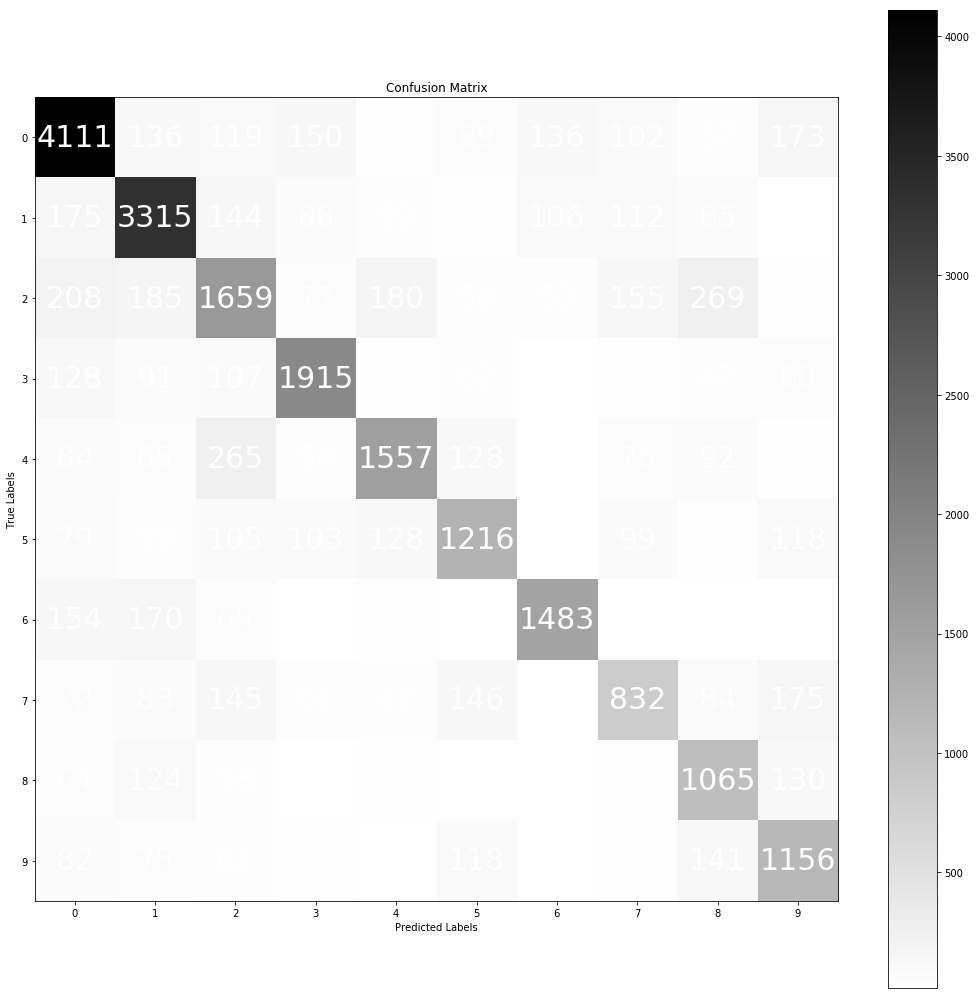

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testing_labels,y_pred)
cm = cm[1:11, 0:10]
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111)
res = ax.imshow(np.array(cm), cmap="binary")

width, height = cm.shape
for x in range(width):
    for y in range(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center', color = 'white', size = 30)
plt.title("Confusion Matrix")
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.yaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

cb = fig.colorbar(res)
plt.show()